## 导入必要的库，这里有区别于上一个，使用pytorch进行

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from pathlib import Path
from sklearn.metrics import confusion_matrix, roc_auc_score

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy

## 解决可视化图像中的中文乱码问题

In [2]:
from matplotlib.font_manager import fontManager
import os
 
fonts = [font.name for font in fontManager.ttflist 
             if os.path.exists(font.fname) and os.stat(font.fname).st_size>1e6]
print(list(fonts))

# 显示中文,解决图中无法显示中文的问题
plt.rcParams['font.sans-serif']=['KaiTi']
 
# 设置显示中文后,负号显示受影响。解决坐标轴上乱码问题
plt.rcParams['axes.unicode_minus']=False

['Calibri', 'STSong', 'HYZhongHei', 'Yu Gothic', 'Calibri', 'Noto Sans SC', 'Ebrima', 'Malgun Gothic', 'SimSun', 'SimSun-ExtG', 'FangSong', 'STXinwei', 'Microsoft YaHei', 'Microsoft JhengHei', 'Segoe UI Variable', 'Cambria', 'STFangsong', 'MS Gothic', 'Calibri', 'Yu Gothic', 'DengXian', 'Malgun Gothic', 'Times New Roman', 'Microsoft JhengHei', 'Noto Sans SC', 'LiSu', 'FZXiaoBiaoSong-B05S', 'YouYuan', 'FZCuHeiSongS-B-GB', 'MingLiU-ExtB', 'Segoe UI Emoji', 'Segoe UI Historic', 'STCaiyun', 'SimHei', 'KaiTi', 'Calibri', 'STXihei', 'FZYaoTi', 'KaiTi_GB2312', 'STHupo', 'Noto Sans SC', 'STZhongsong', 'Source Han Serif SC', 'DengXian', 'Gabriola', 'Calibri', 'Yu Gothic', 'Microsoft JhengHei', 'Microsoft YaHei', 'STKaiti', 'Calibri', 'DengXian', 'FZShuTi', 'FangSong_GB2312', 'Microsoft YaHei', 'SimSun-ExtB', 'Sans Serif Collection', 'Malgun Gothic', 'Arial', 'STLiti', 'Yu Gothic', 'Nirmala UI', 'STXingkai', 'Segoe UI Symbol', 'Times New Roman']


### 1、加载数据集

In [3]:
data_dir = Path('./RetinalOCT_Dataset')

### 2、数据预处理（训练集和验证集）

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # 随机裁剪到224x224
        transforms.RandomHorizontalFlip(),  # 随机水平翻转
        transforms.ToTensor(),              # 转换为张量
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 使用ImageNet均值和标准差进行归一化
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),              # 调整图像大小为256x256
        transforms.CenterCrop(224),          # 中心裁剪到224x224
        transforms.ToTensor(),              # 转换为张量
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

### 3、加载处理过后的训练集和验证集

In [5]:
image_datasets = {x: datasets.ImageFolder(data_dir / x, data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [6]:
class_names = image_datasets['train'].classes # 获取类别名
print(class_names)

['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']


### 显示随机图像

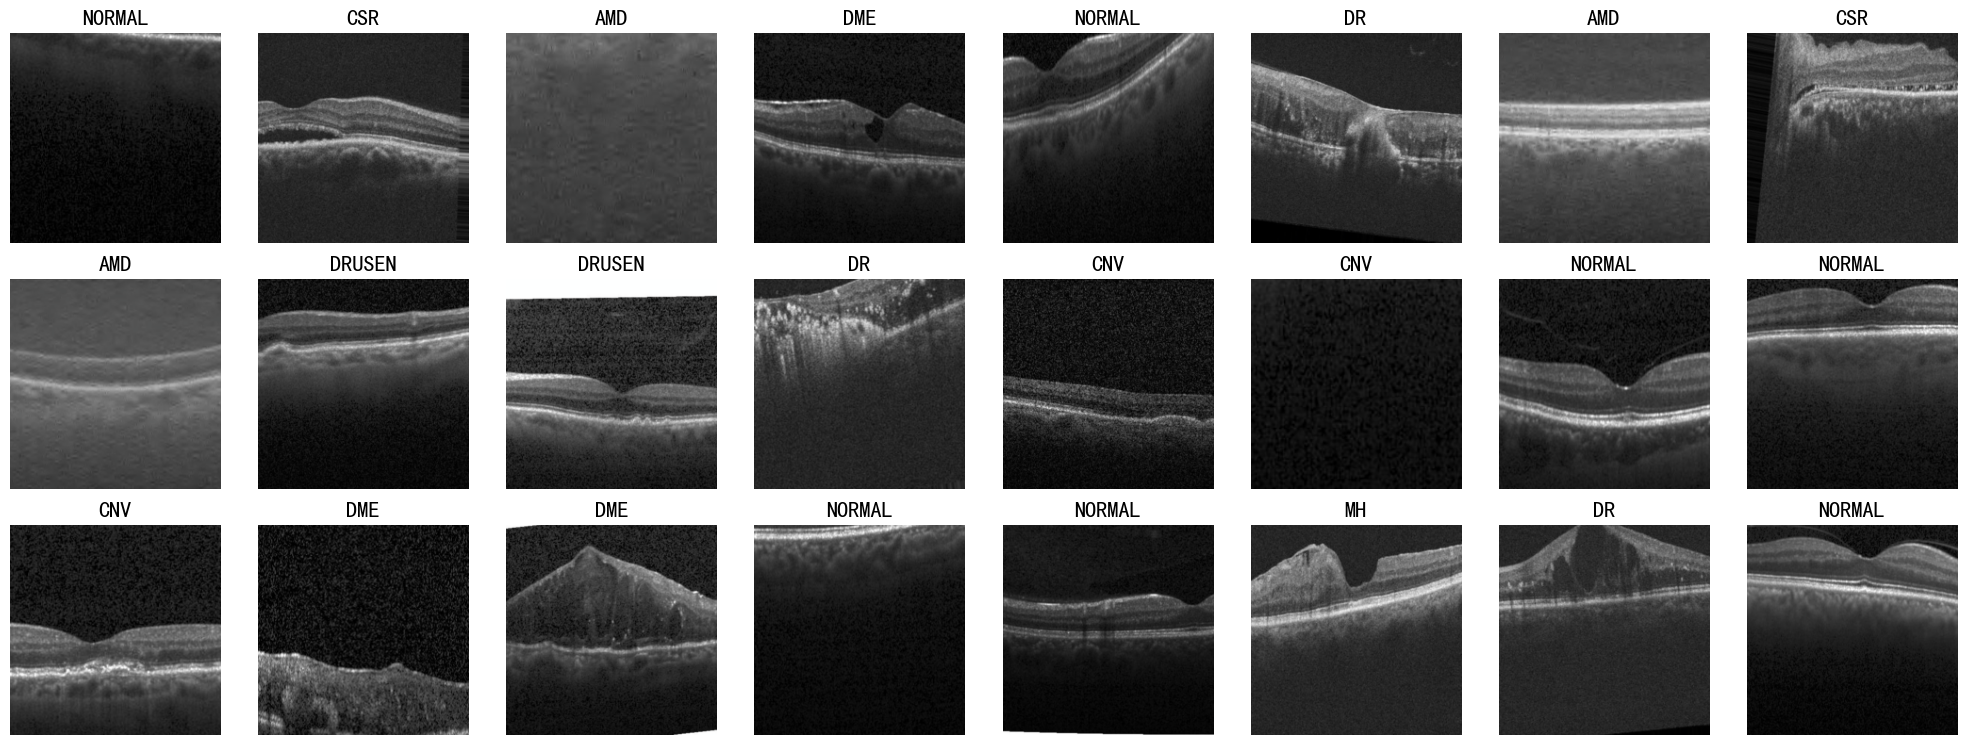

In [7]:
def display(dataset, num_images):
    """显示随机子样本"""
    # 获取一个批次
    batch = next(iter(dataloaders[dataset]))
    images, labels = batch

    # 展示图像
    plt.figure(figsize=(20, 10))
    for i in range(min(num_images, len(images))):
        ax = plt.subplot(4, 8, i + 1)
        image = images[i].numpy().transpose((1, 2, 0))  # 转换到 (H, W, C)
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # 反归一化，显示正常图像
        image = np.clip(image, 0, 1)  # 限制到0-1
        plt.imshow(image)
        plt.title(class_names[labels[i].item()], fontsize=16)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# 显示训练集中的随机图像
display('train', 24)

In [8]:
# 统计训练集和验证集的标签数量
train_labels = []
val_labels = []

with torch.no_grad():
    for _, labels in dataloaders['train']:
        train_labels.append(labels)
    for _, labels in dataloaders['val']:
        val_labels.append(labels)

train_labels = torch.cat(train_labels).numpy()
val_labels = torch.cat(val_labels).numpy()

In [9]:
# 统计每个类别的数量
train_label_counts = np.bincount(train_labels)
val_label_counts = np.bincount(val_labels)
label_counts = train_label_counts + val_label_counts
label_counts

array([2650, 2650, 2650, 2650, 2650, 2650, 2650, 2650], dtype=int64)

### 绘制柱状图

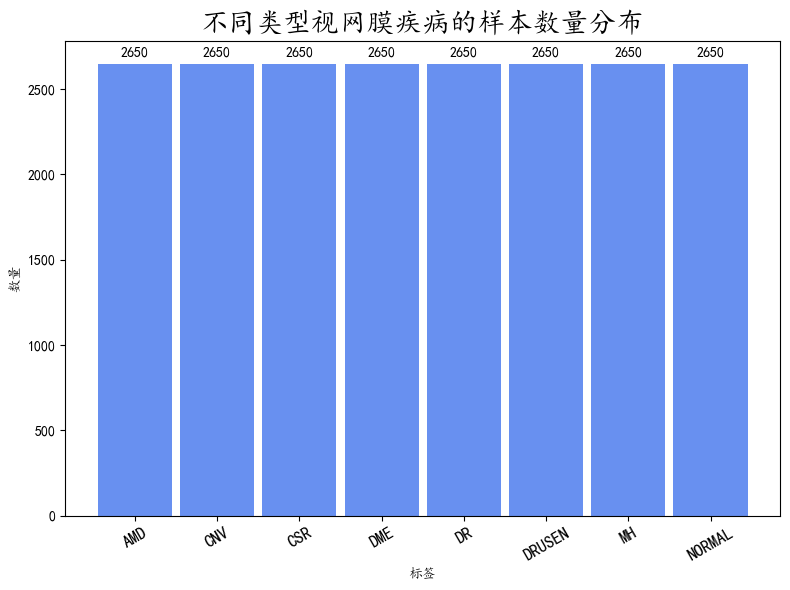

In [10]:
x = np.arange(len(class_names))
width = 0.90

# 创建一个新的图形和坐标轴对象
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

# 在坐标轴上绘制柱状图
rects = ax.bar(x, label_counts, width, color='#6890F0')
ax.set_ylabel('数量')
ax.set_xlabel('标签')
ax.set_title('不同类型视网膜疾病的样本数量分布', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(class_names, fontsize=12, rotation=30)
ax.bar_label(rects, padding=4)  # 数值标签与柱子之间留有4的间距
fig.tight_layout()

plt.show()

## 构建卷积神经网络

### 1、定义模型结构，使用ResNet18模型

### **ResNet18模型和ResNet50模型的区别**
1. 网络深度：ResNet50相比于ResNet18更深，具有更多的层和更多的参数。更深的网络通常有更强的表达能力，可以捕捉到更复杂的特征和模式，这在一些复杂的任务上可能会表现得更好。然而，在某些简单的分类任务上，更深的网络可能会导致过拟合或训练困难，从而降低了准确率。

2. 参数量：ResNet50具有更多的参数量，这意味着它可以学习更多的特征并进行更复杂的表示。但同时，更多的参数也增加了过拟合的风险。较小的ResNet18在某些数据集上可能表现得更好，因为它具有适量的参数来处理任务的特征，并且更不容易过拟合。

3. 数据集大小：不同的数据集规模可能会影响模型的性能。在较小的数据集上，ResNet18可能更容易收敛并表现出较高的准确率。而在更大的数据集上，ResNet50可能由于其更强大的表达能力和更多的参数而获得更好的准确率。

In [8]:
model = models.resnet18(pretrained=True)  # 加载预训练的ResNet18模型
num_ftrs = model.fc.in_features  # 获取全连接层的输入特征数
model.fc = nn.Linear(num_ftrs, 8)  # 替换全连接层为输出8个类别的分类器

# 打印模型结构
# print(model)

D:\WorkSpace\MiniConda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\WorkSpace\MiniConda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 2、定义损失函数及优化器

In [9]:
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # 随机梯度下降优化器

### 3、训练函数

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, patience=5):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # 如果有GPU则使用GPU
    model = model.to(device)  # 将模型移动到GPU/CPU
    best_model_wts = copy.deepcopy(model.state_dict())  # 保存最佳模型权重
    best_val_acc = 0.0  # 最佳验证准确率
    patience_counter = 0  # 耐心计数器

    # 初始化存储训练和验证的损失及准确率的列表
    history = {
        'tr_loss': [],
        'val_loss': [],
        'tr_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):  # 每个epoch的训练和验证
        print(f'Epoch {epoch + 1}/{num_epochs}')  # 打印当前epoch
        print('-' * 10)
        current_val_acc = 0.0  # 当前epoch的验证准确率

        epoch_train_loss = 0.0  # 当前epoch的训练损失
        epoch_train_acc = 0.0   # 当前epoch的训练准确率

        for phase in ['train', 'val']:  # 训练和验证两个阶段
            if phase == 'train':
                model.train()  # 设置模型为训练模式
            else:
                model.eval()   # 设置模型为验证模式

            running_loss = 0.0  # 运行损失
            running_corrects = 0  # 运行正确预测数

            for inputs, labels in dataloaders[phase]:  # 遍历数据集
                inputs = inputs.to(device)  # 将输入数据移动到GPU/CPU
                labels = labels.to(device)  # 将标签移动到GPU/CPU

                optimizer.zero_grad()  # 梯度归零

                with torch.set_grad_enabled(phase == 'train'):  # 是否启用梯度计算
                    outputs = model(inputs)  # 模型输出
                    _, preds = torch.max(outputs, 1)  # 获取预测类别
                    loss = criterion(outputs, labels)  # 计算损失

                    # 仅在训练阶段进行反向传播和梯度更新
                    if phase == 'train':
                        loss.backward()  # 反向传播
                        optimizer.step()  # 更新权重

                # 统计损失和准确率
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # 计算平均损失和准确率
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')  # 打印当前阶段的损失和准确率

            # 记录训练阶段的损失和准确率
            if phase == 'train':
                epoch_train_loss = epoch_loss
                epoch_train_acc = epoch_acc

            # 记录验证集的准确率
            if phase == 'val':
                current_val_acc = epoch_acc

        print()  # 分隔每个epoch的输出

        # 更新训练和验证的损失及准确率历史
        history['tr_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_loss)
        history['tr_acc'].append(epoch_train_acc)
        history['val_acc'].append(current_val_acc)

        # 深度复制最佳模型权重
        if current_val_acc > best_val_acc:
            best_val_acc = current_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0  # 重置耐心计数器
        else:
            patience_counter += 1  # 如果验证准确率没有提升，则增加耐心计数器

        # 如果耐心计数器超过指定的耐心值，则提前停止训练
        if patience_counter >= patience:
            print(f'Validation accuracy has not improved for {patience} epochs. Training stopped.')
            break

    print(f'Best val Acc: {best_val_acc:4f}')  # 打印最佳验证准确率
    model.load_state_dict(best_model_wts)  # 加载最佳模型权重
    return model, history

### 4、模型训练

In [11]:
# 调用训练函数
model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=25, patience=5)

# 获取训练和验证的损失及准确率
tr_loss = history['tr_loss']
val_loss = history['val_loss']
tr_acc = history['tr_acc']
val_acc = history['val_acc']

Epoch 1/25
----------
train Loss: 0.5577 Acc: 0.7821
val Loss: 0.1590 Acc: 0.9414

Epoch 2/25
----------
train Loss: 0.3167 Acc: 0.8785
val Loss: 0.1232 Acc: 0.9579

Epoch 3/25
----------
train Loss: 0.2736 Acc: 0.8944
val Loss: 0.1075 Acc: 0.9650

Epoch 4/25
----------
train Loss: 0.2420 Acc: 0.9070
val Loss: 0.1217 Acc: 0.9607

Epoch 5/25
----------
train Loss: 0.2383 Acc: 0.9080
val Loss: 0.1011 Acc: 0.9671

Epoch 6/25
----------
train Loss: 0.2205 Acc: 0.9139
val Loss: 0.1155 Acc: 0.9632

Epoch 7/25
----------
train Loss: 0.2211 Acc: 0.9141
val Loss: 0.0946 Acc: 0.9696

Epoch 8/25
----------
train Loss: 0.2218 Acc: 0.9129
val Loss: 0.0872 Acc: 0.9704

Epoch 9/25
----------
train Loss: 0.2094 Acc: 0.9176
val Loss: 0.0954 Acc: 0.9693

Epoch 10/25
----------
train Loss: 0.2017 Acc: 0.9233
val Loss: 0.1178 Acc: 0.9611

Epoch 11/25
----------
train Loss: 0.1953 Acc: 0.9243
val Loss: 0.0834 Acc: 0.9721

Epoch 12/25
----------
train Loss: 0.1914 Acc: 0.9243
val Loss: 0.0803 Acc: 0.9739

E

### 5、保存训练好的模型

In [12]:
torch.save(model.state_dict(), 'resnet18_model.pth')  # 保存模型权重
torch.save(image_datasets['train'].class_to_idx, 'class_to_idx.pth')

## 模型训练 metric 绘制

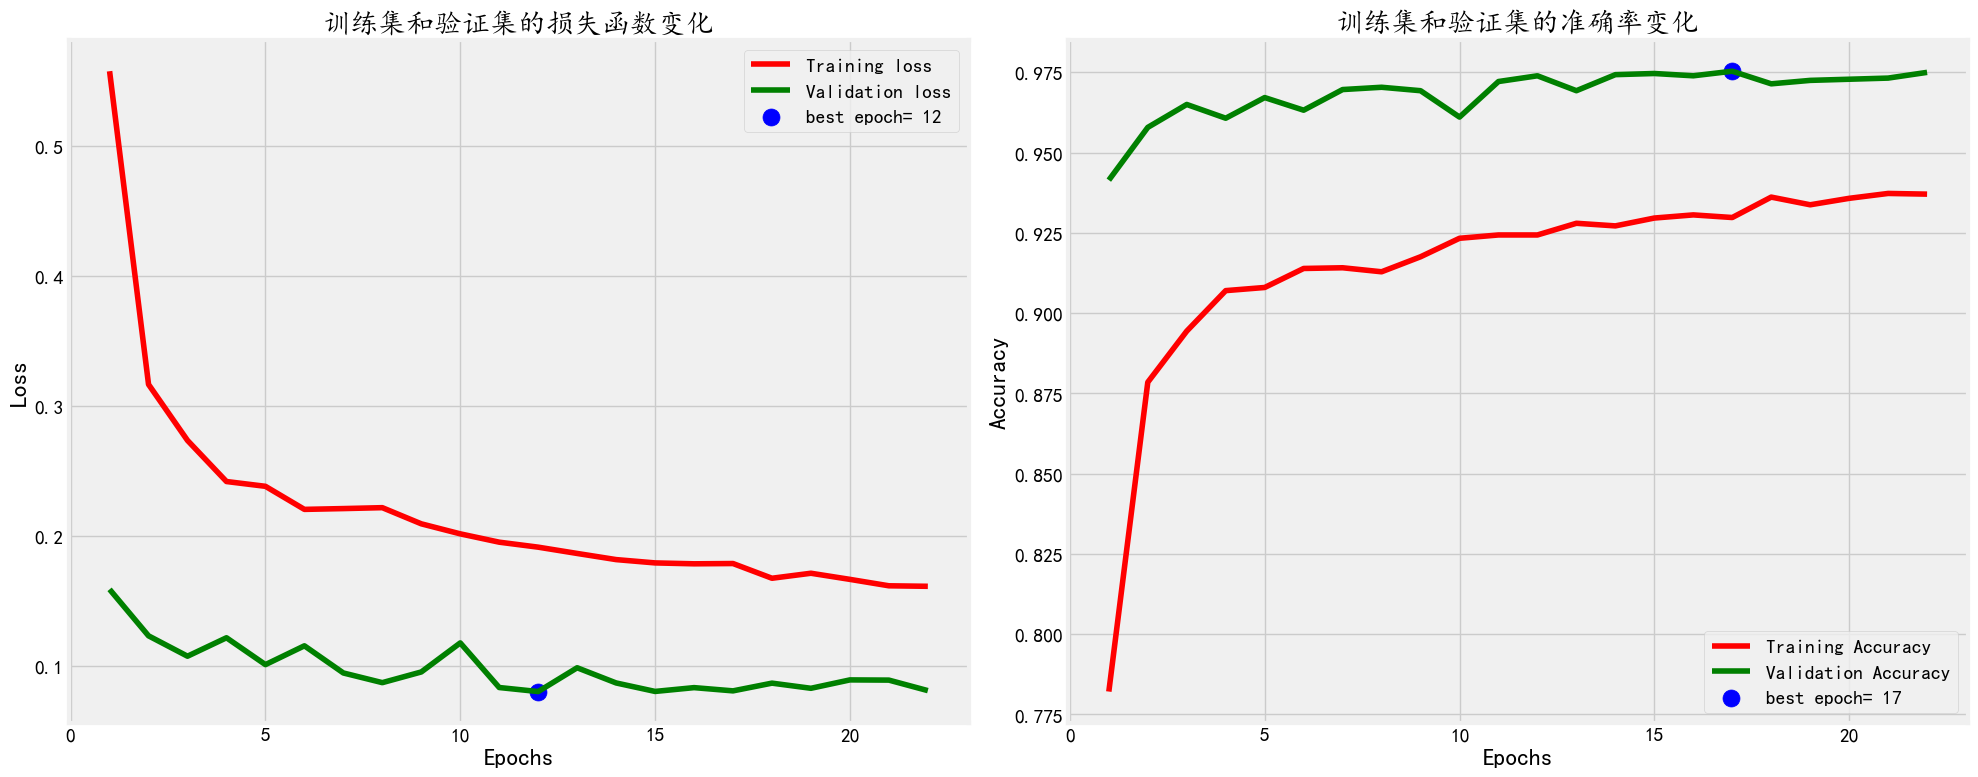

In [13]:
# 获取训练和验证的损失及准确率
tr_loss = list(map(float, history['tr_loss'])) # 使张量恒为浮点数，以便绘图
val_loss = list(map(float, history['val_loss']))
tr_acc = list(map(float, history['tr_acc']))
val_acc = list(map(float, history['val_acc']))

Epochs = [i + 1 for i in range(len(tr_loss))]
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('训练集和验证集的损失函数变化')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('训练集和验证集的准确率变化')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 验证集预测性能评估

In [14]:
from sklearn.metrics import roc_auc_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
with torch.no_grad():
    val_labels = []
    pred_pros = []  # 收集概率分数
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # 如果模型输出的是logits，需要先转换为概率
        if isinstance(outputs, torch.Tensor):
            outputs = torch.softmax(outputs, dim=1)
        pred_pros.extend(outputs.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# 转换为 numpy 数组
val_labels = np.array(val_labels)
pred_pros = np.array(pred_pros)

roc_sum = 0
cate_auc = []
for i in range(len(class_names)):
    # 确保 y_true 为二进制格式
    y_true = (val_labels == i).astype(int)
    score = roc_auc_score(y_true, pred_pros[:, i])
    cate_auc.append(score)
    roc_sum += score
    print(f'{class_names[i]} AUC: {score:.4f}')
    
roc_sum /= len(class_names)
print(f'模型预测平均 AUC: {roc_sum:.3f}')

AMD AUC: 1.0000
CNV AUC: 0.9966
CSR AUC: 1.0000
DME AUC: 0.9983
DR AUC: 1.0000
DRUSEN AUC: 0.9967
MH AUC: 1.0000
NORMAL AUC: 0.9982
模型预测平均 AUC: 0.999


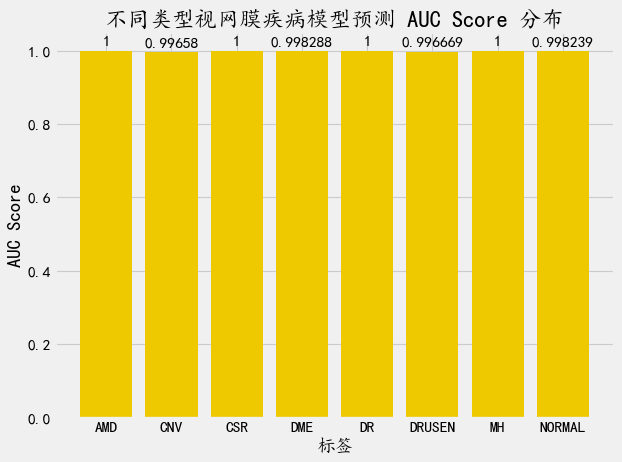

In [15]:
# 绘制 AUC 分布图
x = np.arange(len(class_names))
width = 0.80
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
rects = ax.bar(x, cate_auc, width, color='#EEC900')
ax.set_ylabel('AUC Score')
ax.set_xlabel('标签')
ax.set_title('不同类型视网膜疾病模型预测 AUC Score 分布')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.bar_label(rects, padding=3)
fig.tight_layout()
plt.show()

### 绘制混淆矩阵

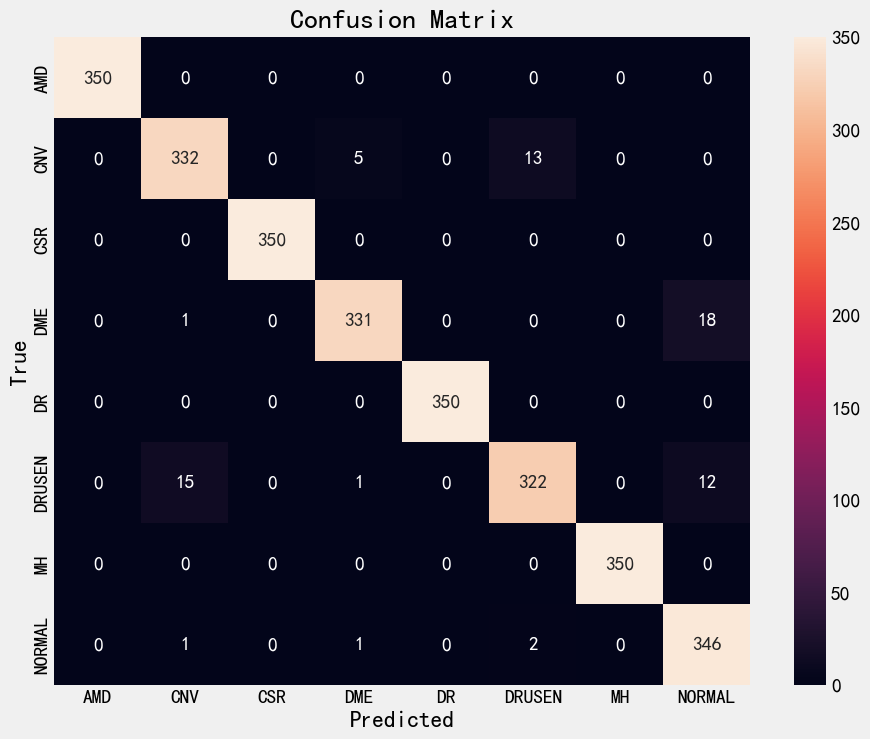

In [16]:
# 将预测概率转换为类别标签
pred_labels = np.argmax(pred_pros, axis=1)

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
cm = confusion_matrix(val_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()